In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from math import sqrt
import statsmodels.tsa.arima.model as sm_arima
from datetime import datetime
import statsmodels.api as sm
import plotly.express as px
import xgboost as xgb
from prophet import Prophet
from statsmodels.tsa.stattools import adfuller

In [3]:
# Read the data from CSV file
df = pd.read_csv('data/PJME_hourly.csv', index_col=[0], parse_dates=[0])

In [4]:
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [5]:
# Rename the column 'PJME_MW' to 'Energy Consumption'
df.rename(columns={'PJME_MW': 'Energy Consumption'}, inplace=True)

In [6]:
# Identify and manage duplicate indices in the DataFrame
duplicate_index = df[df.index.duplicated()]
df.loc[duplicate_index.index.values, :]

,Energy Consumption
Datetime,
2014-11-02 02:00:00,22935.0
2014-11-02 02:00:00,23755.0
2015-11-01 02:00:00,21567.0
2015-11-01 02:00:00,21171.0
2016-11-06 02:00:00,20795.0
2016-11-06 02:00:00,21692.0
2017-11-05 02:00:00,21236.0
2017-11-05 02:00:00,20666.0


In [7]:
# Replace duplicate values with the mean value
df = df.groupby('Datetime').agg(np.mean)

# Set the frequency of the DatetimeIndex to hourly
df = df.asfreq('H')
df

,Energy Consumption
Datetime,
2002-01-01 01:00:00,30393.0
2002-01-01 02:00:00,29265.0
2002-01-01 03:00:00,28357.0
2002-01-01 04:00:00,27899.0
2002-01-01 05:00:00,28057.0
...,...
2018-08-02 20:00:00,44057.0
2018-08-02 21:00:00,43256.0
2018-08-02 22:00:00,41552.0


In [8]:
# Determine # of Missing Values
print('# of Missing Energy Consumption Values: {}'.format(len(df[df['Energy Consumption'].isna()])))

# of Missing Energy Consumption Values: 30


In [9]:
# Impute Missing Values
df['Energy Consumption'] = df['Energy Consumption'].interpolate(limit_area='inside', limit=None)

In [10]:
# Check if any null values exist in the DataFrame
if df.isnull().any().any():
    print("Null values exist in the DataFrame")
else:
    print("No null values found in the DataFrame")

No null values found in the DataFrame


In [11]:
# Create a copy of the original DataFrame
df_orig = df.copy()

In [12]:
# Create additional time series features based on the time series index
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['Hour'] = df.index.hour
    df['DayofWeek'] = df.index.dayofweek
    df['Quarter'] = df.index.quarter
    df['Month'] = df.index.month
    df['Year'] = df.index.year
    df['DayOfYear'] = df.index.dayofyear
    df['DayOfMonth'] = df.index.day
    df['WeekOfYear'] = df.index.isocalendar().week
    df['DayOfYearFloat'] = df['DayOfYear'] + df['Hour'] / 24
    return df

df = create_features(df)

In [13]:
df

,Energy Consumption,Hour,DayofWeek,Quarter,Month,Year,DayOfYear,DayOfMonth,WeekOfYear,DayOfYearFloat
Datetime,,,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,1,1,1.041667
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,1,1,1.083333
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,1,1,1.125000
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,1,1,1.166667
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,1,1,1.208333
...,...,...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,2,31,214.833333
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,2,31,214.875000
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,2,31,214.916667


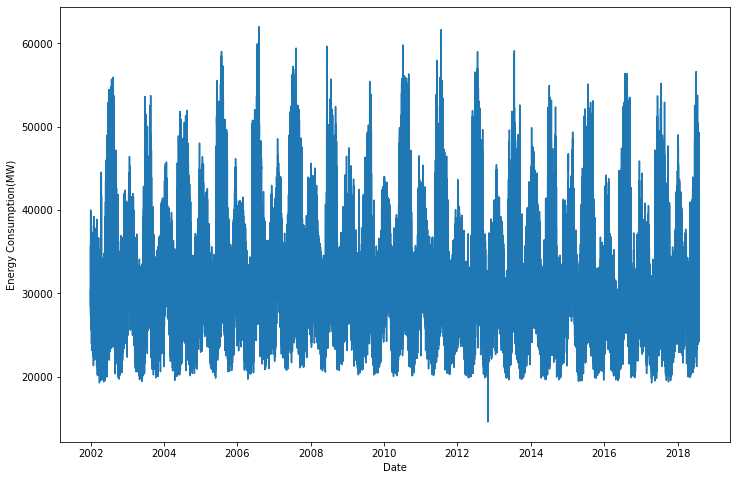

In [14]:
# Plot the energy consumption over time
plt.figure(figsize=(12, 8))
plt.plot(df.index, df['Energy Consumption'])
plt.xlabel('Date')
plt.ylabel('Energy Consumption(MW)')
plt.show()


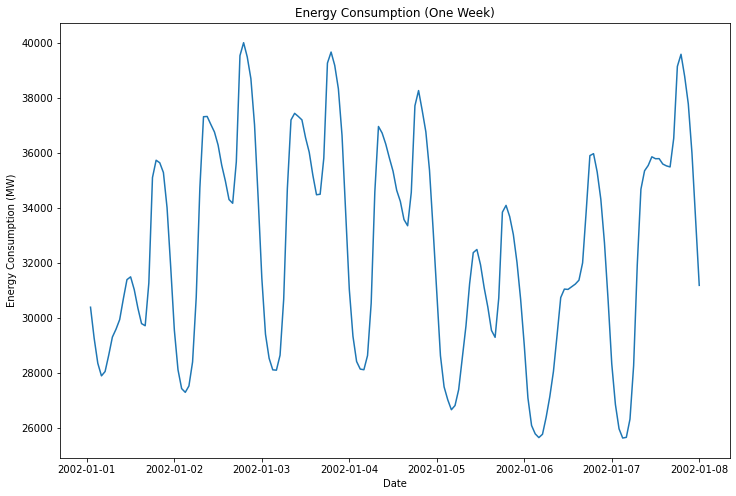

In [15]:
# Plot the energy consumption for one week
WEEK_END_INDEX = 7*24
plt.figure(figsize=(12, 8))
plt.plot(df.index[:WEEK_END_INDEX], df['Energy Consumption'][:WEEK_END_INDEX])
plt.title('Energy Consumption (One Week)')
plt.xlabel('Date')
plt.ylabel('Energy Consumption (MW)')
plt.show()

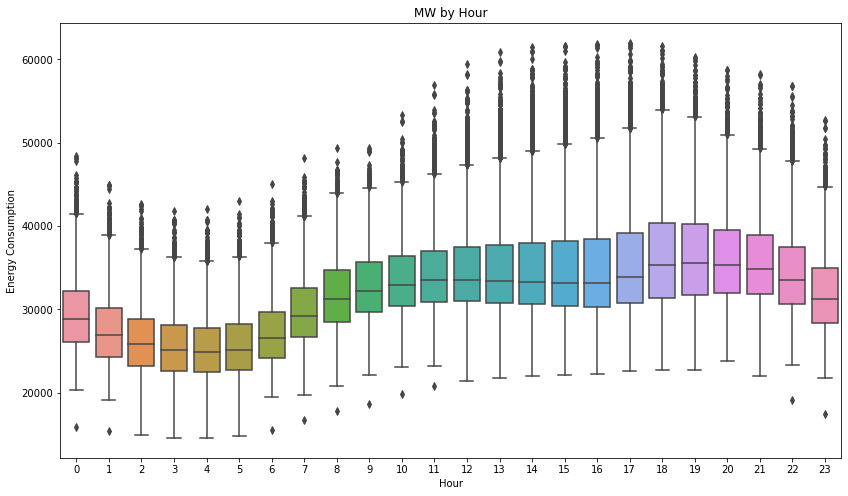

In [16]:
# Boxplot by Hour
fig, ax = plt.subplots(figsize=(14, 8))
sns.boxplot(data=df, x='Hour', y='Energy Consumption')
ax.set_title('MW by Hour')
plt.show()

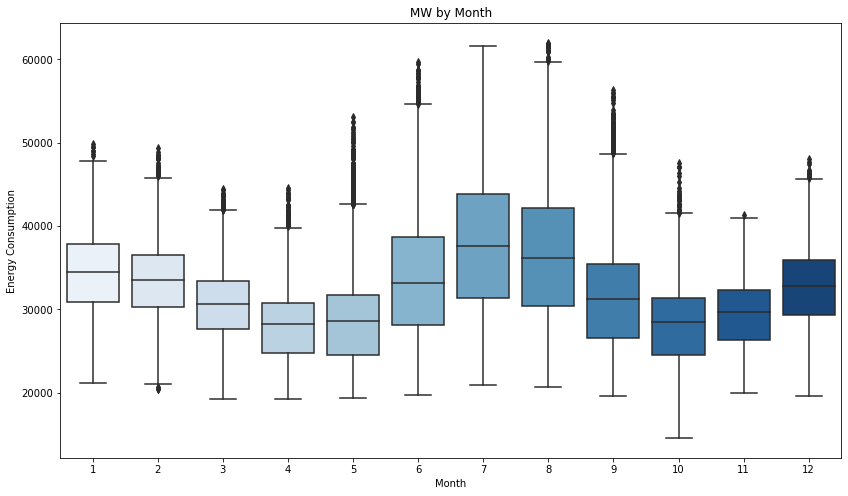

In [17]:
# Boxplot by Month
fig, ax = plt.subplots(figsize=(14, 8))
sns.boxplot(data=df, x='Month', y='Energy Consumption', palette='Blues')
ax.set_title('MW by Month')
plt.show()

In [18]:
# Seasonal Plot
df = df.copy()
year_group = df.groupby(['Year', 'Month']).mean().reset_index()
year_group

,Year,Month,Energy Consumption,Hour,DayofWeek,Quarter,DayOfYear,DayOfMonth,WeekOfYear,DayOfYearFloat
0,2002,1,31075.399731,11.515478,2.905787,1.0,16.020188,16.020188,2.873486,16.500000
1,2002,2,30239.166667,11.500000,3.000000,1.0,45.500000,14.500000,7.071429,45.979167
2,2002,3,28875.256720,11.500000,3.193548,1.0,75.000000,16.000000,11.258065,75.479167
3,2002,4,28529.284028,11.500000,2.833333,2.0,105.500000,15.500000,15.666667,105.979167
4,2002,5,28073.653226,11.500000,3.000000,2.0,136.000000,16.000000,20.0,136.479167
...,...,...,...,...,...,...,...,...,...,...
195,2018,4,27353.266667,11.500000,3.000000,2.0,105.500000,15.500000,15.5,105.979167
196,2018,5,28599.951613,11.500000,2.903226,2.0,136.000000,16.000000,19.870968,136.479167
197,2018,6,32014.469444,11.500000,3.100000,2.0,166.500000,15.500000,24.2,166.979167
198,2018,7,36696.737903,11.500000,2.935484,3.0,197.000000,16.000000,28.580645,197.479167


In [19]:
# Get unique years
years = df['Year']
years

Datetime
2002-01-01 01:00:00    2002
2002-01-01 02:00:00    2002
2002-01-01 03:00:00    2002
2002-01-01 04:00:00    2002
2002-01-01 05:00:00    2002
                       ... 
2018-08-02 20:00:00    2018
2018-08-02 21:00:00    2018
2018-08-02 22:00:00    2018
2018-08-02 23:00:00    2018
2018-08-03 00:00:00    2018
Freq: H, Name: Year, Length: 145392, dtype: int64

In [20]:
years = df['Year'].unique()
NUM_COLORS = len(years)

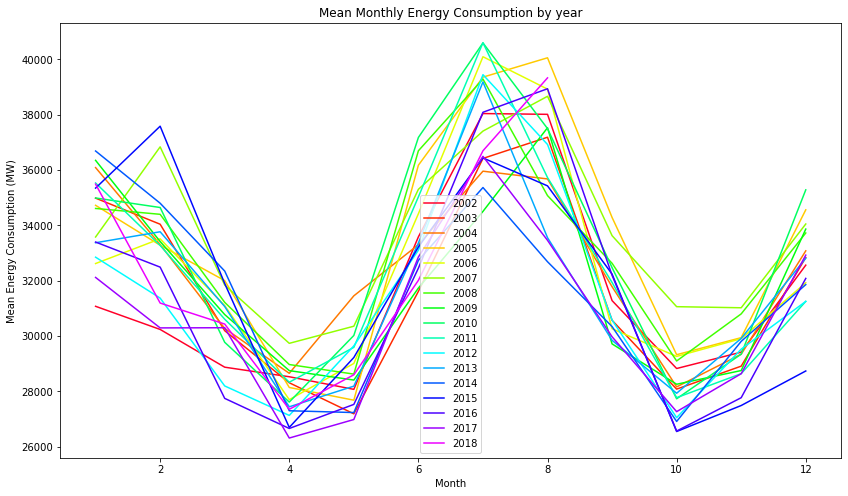

In [21]:
# Plot mean monthly energy consumption for each year
cm = plt.get_cmap('gist_rainbow')
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111)
ax.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

for i, y in enumerate(years):
    df1 = year_group[year_group['Year'] == y]
    #rolling_mean = df.rolling(window=7*24).mean()
    plt.plot(df1['Month'], df1['Energy Consumption'])

plt.title('Mean Monthly Energy Consumption by year')
plt.xlabel('Month')
plt.ylabel('Mean Energy Consumption (MW)')
plt.legend(df.Year.unique())
plt.show()

In [22]:
# Moving Average (Smoothing)
MONTH_PERIOD = 24*30
MIDYEAR_PERIOD = 24*182
YEAR_PERIOD = 24*365

# Calculate rolling means
month_roll = df.rolling(MONTH_PERIOD).mean()
midyear_roll = df.rolling(MIDYEAR_PERIOD).mean()
year_roll = df.rolling(YEAR_PERIOD).mean()

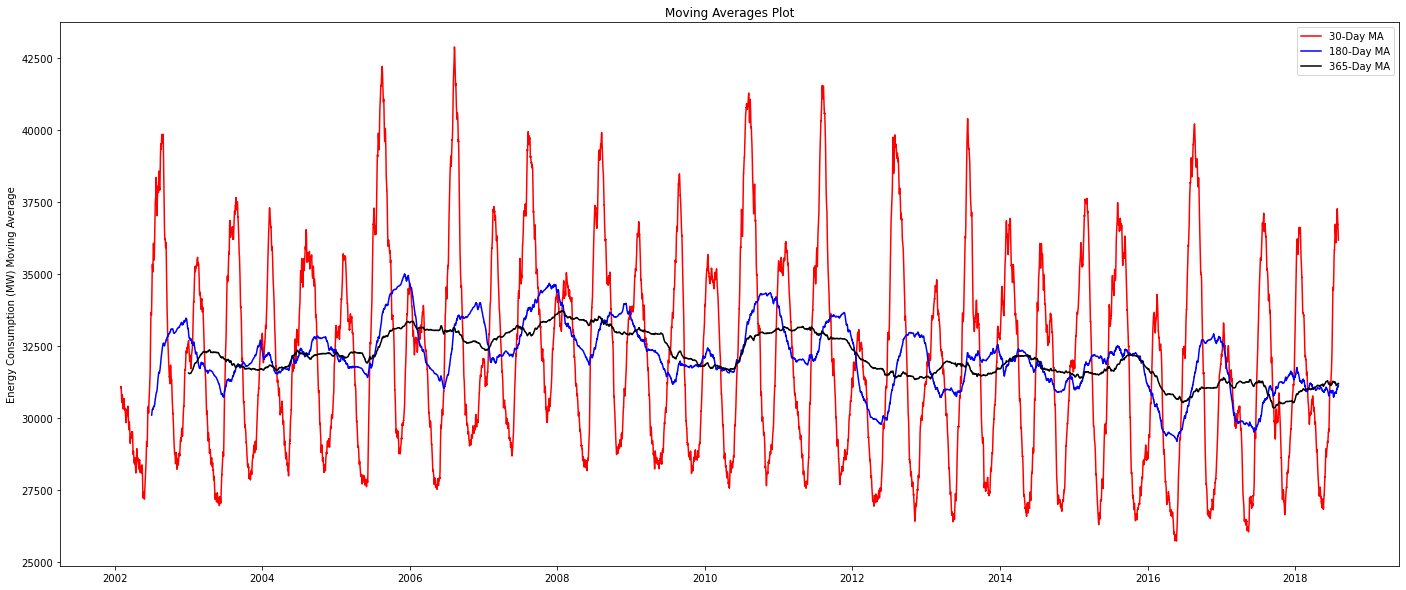

In [23]:
# Plot moving averages
fig, ax = plt.subplots(figsize=(24, 10))
plt.plot(month_roll.index, month_roll['Energy Consumption'], color='red', label='30-Day MA')
plt.plot(midyear_roll.index, midyear_roll['Energy Consumption'], color='blue', label='180-Day MA')
plt.plot(year_roll.index, year_roll['Energy Consumption'], color='black', label='365-Day MA')
plt.title('Moving Averages Plot')
plt.ylabel('Energy Consumption (MW) Moving Average')
plt.legend()
plt.show()

# ARIMA Models

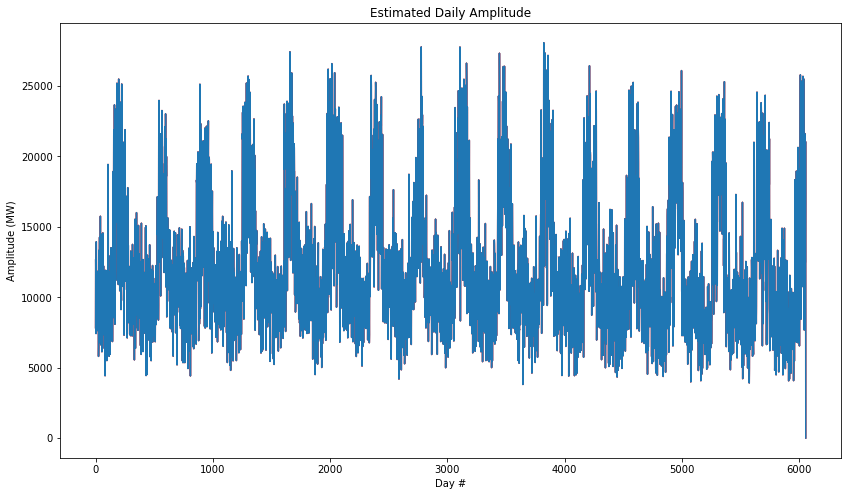

In [24]:
# Calculate estimated daily amplitude
max_daily_vals = df.groupby(['Year', 'DayOfYear']).max()['Energy Consumption'].values
min_daily_vals = df.groupby(['Year', 'DayOfYear']).min()['Energy Consumption'].values
daily_amp = max_daily_vals - min_daily_vals
fig = plt.figure(figsize=(14, 8))
plt.plot(daily_amp, color='red')
plt.plot(daily_amp)
plt.xlabel('Day #')
plt.ylabel('Amplitude (MW)')
plt.title('Estimated Daily Amplitude')
plt.show()

Time Series = Trend Component × Seasonal Component × Residual Component

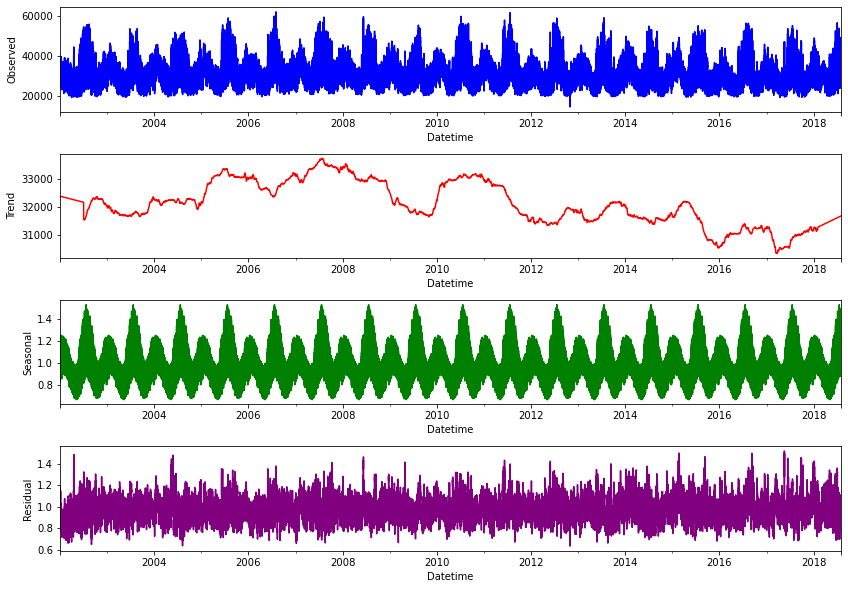

In [25]:
# Perform multiplicative decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

ANNUAL_PERIOD = 365 * 24
mult_decomp = seasonal_decompose(df['Energy Consumption'], model='multiplicative', extrapolate_trend='freq', period=ANNUAL_PERIOD)

fig, axes = plt.subplots(4, 1, figsize=(14, 10))
colors = ['blue', 'red', 'green', 'purple']

# Adjust the size of each subplot
fig.subplots_adjust(hspace=0.4)

mult_decomp.observed.plot(ax=axes[0], color=colors[0])
axes[0].set_ylabel('Observed')

mult_decomp.trend.plot(ax=axes[1], color=colors[1])
axes[1].set_ylabel('Trend')

mult_decomp.seasonal.plot(ax=axes[2], color=colors[2])
axes[2].set_ylabel('Seasonal')

mult_decomp.resid.plot(ax=axes[3], color=colors[3])
axes[3].set_ylabel('Residual')

plt.show()


In [26]:
# Check stationarity using the Augmented Dickey Fuller (ADF) test
adf_result = adfuller(df['Energy Consumption'])
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

ADF Statistic: -19.964593931840557
p-value: 0.0


A p-value of zero or very close to zero may indicate a strong rejection of the null hypothesis, but it does not necessarily imply stationarity.

### Differencing

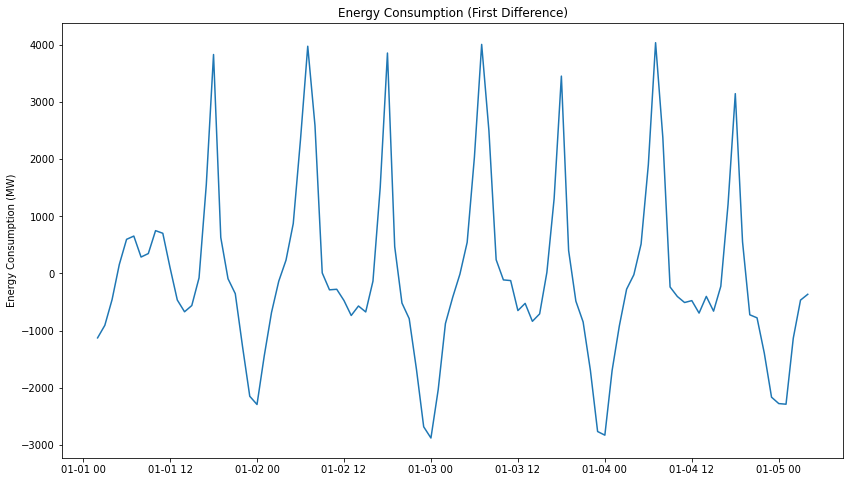

In [27]:
# First Difference (First 100 Values)
df['first_difference'] = df['Energy Consumption'] - df['Energy Consumption'].shift(1)
fig = plt.figure(figsize=(14, 8))
plt.plot(df.index[:100], df['first_difference'][:100])
plt.title('Energy Consumption (First Difference)')
plt.ylabel('Energy Consumption (MW)')
plt.show()

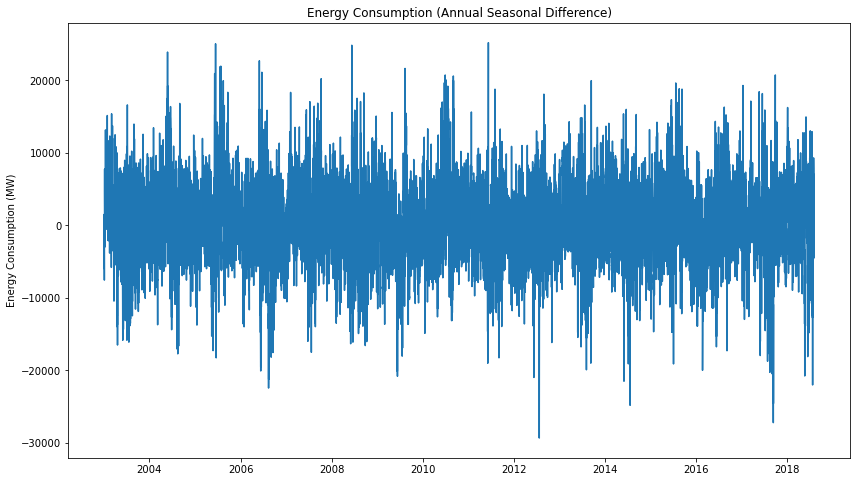

In [28]:
# Annual Seasonal Difference (First 1000 Values)
ANNUAL_SHIFT = 24*365

df['seasonal_difference'] = df['Energy Consumption'] - df['Energy Consumption'].shift(ANNUAL_SHIFT)
fig = plt.figure(figsize=(14, 8))
plt.plot(df.index, df['seasonal_difference'])
plt.title('Energy Consumption (Annual Seasonal Difference)')
plt.ylabel('Energy Consumption (MW)')
plt.show()

In [29]:
# Perform Augmented Dickey-Fuller test
adf_result = adfuller(df['seasonal_difference'][ANNUAL_SHIFT:])

print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

ADF Statistic: -28.03725864435149
p-value: 0.0


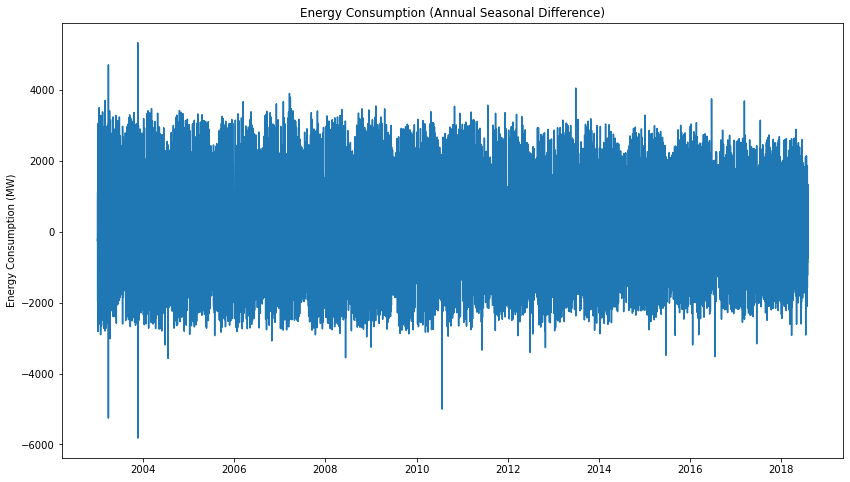

In [30]:
df['seasonal_first_difference'] = df['first_difference'] - df['first_difference'].shift(ANNUAL_SHIFT)
fig = plt.figure(figsize=(14, 8))
plt.plot(df.index, df['seasonal_first_difference'])
plt.title('Energy Consumption (Annual Seasonal Difference)')
plt.ylabel('Energy Consumption (MW)')
plt.show()

In [31]:
# Perform Augmented Dickey-Fuller test
adf_result = adfuller(df['seasonal_first_difference'][ANNUAL_SHIFT+1:])

print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

ADF Statistic: -55.15109886173637
p-value: 0.0


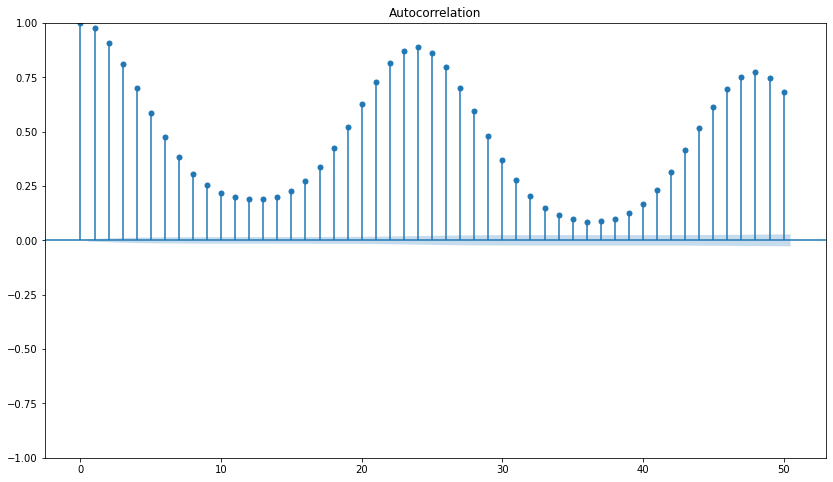

In [32]:
# Plot autocorrelation
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(14, 8))
# Plot autocorrelation
plot_acf(df['Energy Consumption'], lags=50, ax=ax)
plt.show()

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


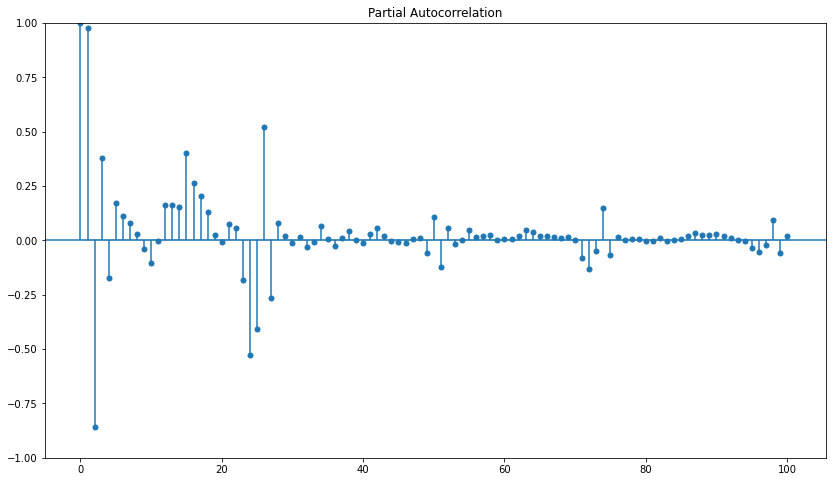

In [33]:
# Plot partial autocorrelation
from statsmodels.graphics.tsaplots import plot_pacf
fig, ax = plt.subplots(figsize=(14, 8))
plot_pacf(df['Energy Consumption'], lags=100, ax=ax)
plt.show()

RMSE Score on Test set: 1842.51


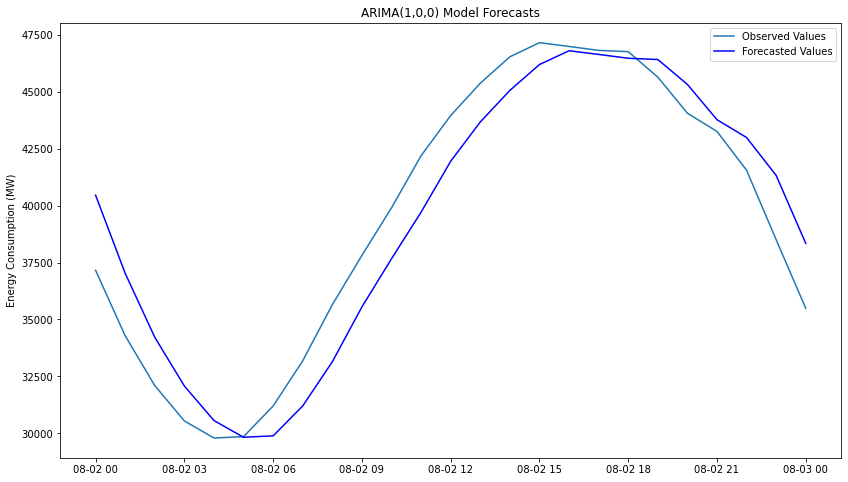

In [34]:
# Baseline ARIMA Models
train_series = df.loc[(df.index >= datetime(2015, 1, 1)) & (df.index < datetime(2018, 8, 2)), 'Energy Consumption']
test_series = df.loc[(df.index >= datetime(2018, 8, 2)), 'Energy Consumption']


# Check if train_series and test_series contain valid data
if train_series.empty or test_series.empty:
    print("Error: Empty train_series or test_series")
    exit()

# Check if train_series and test_series have valid indexes
if not train_series.index.is_unique or not test_series.index.is_unique:
    print("Error: Non-unique indexes in train_series or test_series")
    exit()

ar_preds = []
history = train_series.tolist()

# ARIMA(1,0,0) Model

for t in range(len(test_series)):
    model = sm_arima.ARIMA(history, order=(1, 0, 0))
    model_fit = model.fit()
    output = model_fit.forecast(steps=1)  # Specify the number of steps to forecast
    ar_preds.append(output[0])  # Access the forecasted value directly
    history.append(test_series.iloc[t])  # Use iloc for indexing

ar_pred_series = pd.Series(ar_preds, index=test_series.index)

score = np.sqrt(mean_squared_error(ar_pred_series, test_series))
print(f'RMSE Score on Test set: {score:0.2f}')

fig, ax = plt.subplots(figsize=(14, 8))
plt.plot(test_series, label='Observed Values')
plt.plot(ar_pred_series, color='blue', label='Forecasted Values')
plt.legend()
plt.title('ARIMA(1,0,0) Model Forecasts')
plt.ylabel('Energy Consumption (MW)')
plt.show()


RMSE Score on Test set: 1866.22


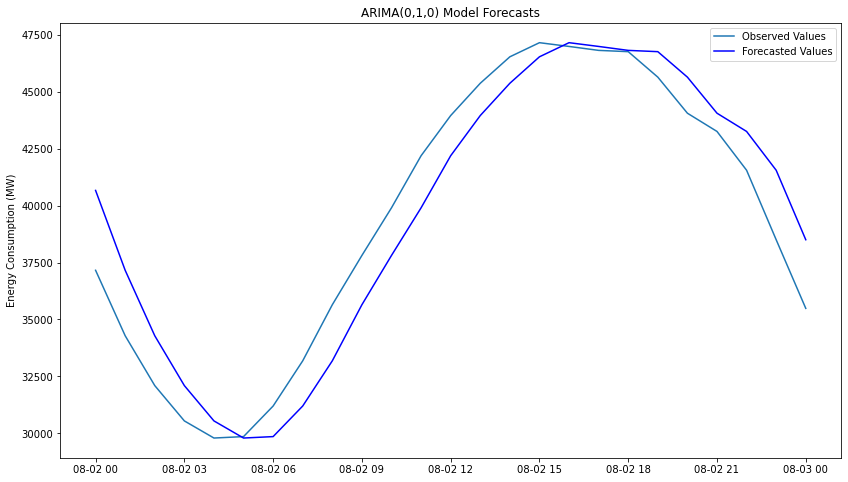

In [37]:
# ARIMA(0, 1, 0) model

train_series = df.loc[(df.index >= datetime(2015, 1, 1)) & (df.index < datetime(2018, 8, 2)), 'Energy Consumption']
test_series = df.loc[(df.index >= datetime(2018, 8, 2)), 'Energy Consumption']


# Check if train_series and test_series contain valid data
if train_series.empty or test_series.empty:
    print("Error: Empty train_series or test_series")
    exit()

# Check if train_series and test_series have valid indexes
if not train_series.index.is_unique or not test_series.index.is_unique:
    print("Error: Non-unique indexes in train_series or test_series")
    exit()

ar_preds = []
history = train_series.tolist()

for t in range(len(test_series)):
    model = sm_arima.ARIMA(history, order=(0, 1, 0))
    model_fit = model.fit()
    output = model_fit.forecast(steps=1)  # Specify the number of steps to forecast
    ar_preds.append(output[0])  # Access the forecasted value directly
    history.append(test_series.iloc[t])  # Use iloc for indexing

ar_pred_series = pd.Series(ar_preds, index=test_series.index)

score = np.sqrt(mean_squared_error(ar_pred_series, test_series))
print(f'RMSE Score on Test set: {score:0.2f}')

fig, ax = plt.subplots(figsize=(14, 8))
plt.plot(test_series, label='Observed Values')
plt.plot(ar_pred_series, color='blue', label='Forecasted Values')
plt.legend()
plt.title('ARIMA(0,1,0) Model Forecasts')
plt.ylabel('Energy Consumption (MW)')
plt.show()

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


RMSE Score on Test set: 5156.50


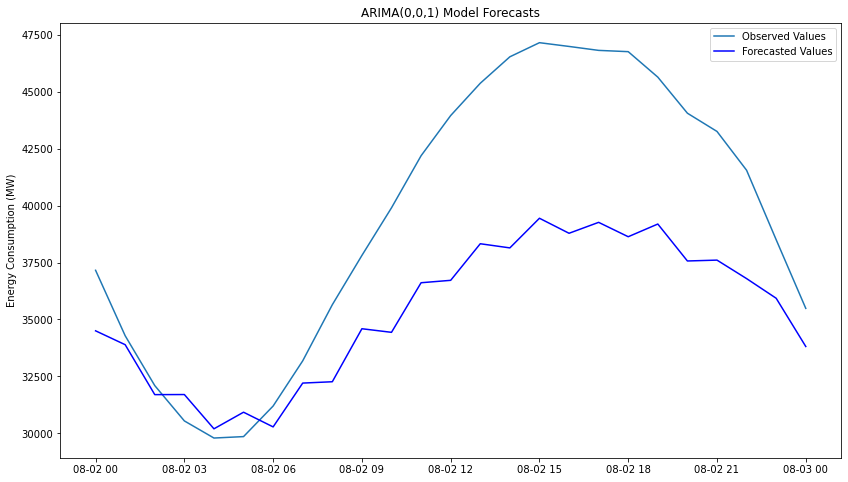

In [38]:
# ARIMA(0, 0, 1) model

train_series = df.loc[(df.index >= datetime(2015, 1, 1)) & (df.index < datetime(2018, 8, 2)), 'Energy Consumption']
test_series = df.loc[(df.index >= datetime(2018, 8, 2)), 'Energy Consumption']


# Check if train_series and test_series contain valid data
if train_series.empty or test_series.empty:
    print("Error: Empty train_series or test_series")
    exit()

# Check if train_series and test_series have valid indexes
if not train_series.index.is_unique or not test_series.index.is_unique:
    print("Error: Non-unique indexes in train_series or test_series")
    exit()

ar_preds = []
history = train_series.tolist()

for t in range(len(test_series)):
    model = sm_arima.ARIMA(history, order=(0, 0, 1))
    model_fit = model.fit()
    output = model_fit.forecast(steps=1)  # Specify the number of steps to forecast
    ar_preds.append(output[0])  # Access the forecasted value directly
    history.append(test_series.iloc[t])  # Use iloc for indexing

ar_pred_series = pd.Series(ar_preds, index=test_series.index)

score = np.sqrt(mean_squared_error(ar_pred_series, test_series))
print(f'RMSE Score on Test set: {score:0.2f}')

fig, ax = plt.subplots(figsize=(14, 8))
plt.plot(test_series, label='Observed Values')
plt.plot(ar_pred_series, color='blue', label='Forecasted Values')
plt.legend()
plt.title('ARIMA(0,0,1) Model Forecasts')
plt.ylabel('Energy Consumption (MW)')
plt.show()

RMSE Score on Test set: 545.62


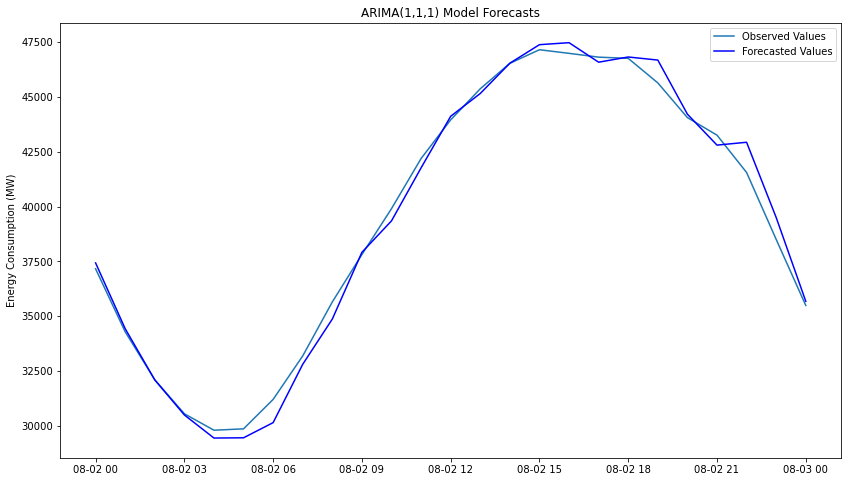

In [39]:
# ARIMA(1, 1, 1) model

train_series = df.loc[(df.index >= datetime(2015, 1, 1)) & (df.index < datetime(2018, 8, 2)), 'Energy Consumption']
test_series = df.loc[(df.index >= datetime(2018, 8, 2)), 'Energy Consumption']


# Check if train_series and test_series contain valid data
if train_series.empty or test_series.empty:
    print("Error: Empty train_series or test_series")
    exit()

# Check if train_series and test_series have valid indexes
if not train_series.index.is_unique or not test_series.index.is_unique:
    print("Error: Non-unique indexes in train_series or test_series")
    exit()

ar_preds = []
history = train_series.tolist()

for t in range(len(test_series)):
    model = sm_arima.ARIMA(history, order=(1, 1, 1))
    model_fit = model.fit()
    output = model_fit.forecast(steps=1)  # Specify the number of steps to forecast
    ar_preds.append(output[0])  # Access the forecasted value directly
    history.append(test_series.iloc[t])  # Use iloc for indexing

ar_pred_series = pd.Series(ar_preds, index=test_series.index)

score = np.sqrt(mean_squared_error(ar_pred_series, test_series))
print(f'RMSE Score on Test set: {score:0.2f}')

fig, ax = plt.subplots(figsize=(14, 8))
plt.plot(test_series, label='Observed Values')
plt.plot(ar_pred_series, color='blue', label='Forecasted Values')
plt.legend()
plt.title('ARIMA(1,1,1) Model Forecasts')
plt.ylabel('Energy Consumption (MW)')
plt.show()

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarnin

RMSE Score on Test set: 473.61


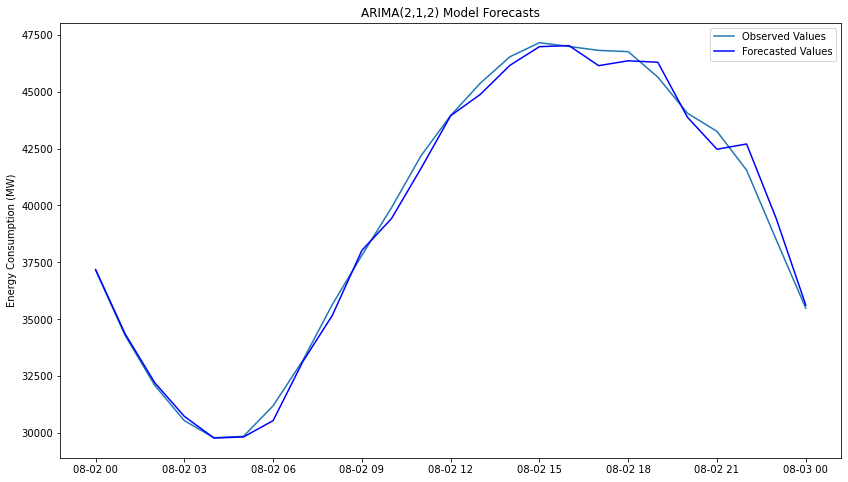

In [40]:
# ARIMA(2, 1, 2) model

train_series = df.loc[(df.index >= datetime(2015, 1, 1)) & (df.index < datetime(2018, 8, 2)), 'Energy Consumption']
test_series = df.loc[(df.index >= datetime(2018, 8, 2)), 'Energy Consumption']


# Check if train_series and test_series contain valid data
if train_series.empty or test_series.empty:
    print("Error: Empty train_series or test_series")
    exit()

# Check if train_series and test_series have valid indexes
if not train_series.index.is_unique or not test_series.index.is_unique:
    print("Error: Non-unique indexes in train_series or test_series")
    exit()

ar_preds = []
history = train_series.tolist()

for t in range(len(test_series)):
    model = sm_arima.ARIMA(history, order=(2, 1, 2))
    model_fit = model.fit()
    output = model_fit.forecast(steps=1)  # Specify the number of steps to forecast
    ar_preds.append(output[0])  # Access the forecasted value directly
    history.append(test_series.iloc[t])  # Use iloc for indexing

ar_pred_series = pd.Series(ar_preds, index=test_series.index)

score = np.sqrt(mean_squared_error(ar_pred_series, test_series))
print(f'RMSE Score on Test set: {score:0.2f}')

fig, ax = plt.subplots(figsize=(14, 8))
plt.plot(test_series, label='Observed Values')
plt.plot(ar_pred_series, color='blue', label='Forecasted Values')
plt.legend()
plt.title('ARIMA(2,1,2) Model Forecasts')
plt.ylabel('Energy Consumption (MW)')
plt.show()

In [197]:
score = np.sqrt(mean_squared_error(ar_pred_series, test_series))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 473.62


## Gradient Boosting Model

In [165]:
df_orig

,Energy Consumption
Datetime,
2002-01-01 01:00:00,30393.0
2002-01-01 02:00:00,29265.0
2002-01-01 03:00:00,28357.0
2002-01-01 04:00:00,27899.0
2002-01-01 05:00:00,28057.0
...,...
2018-08-02 20:00:00,44057.0
2018-08-02 21:00:00,43256.0
2018-08-02 22:00:00,41552.0


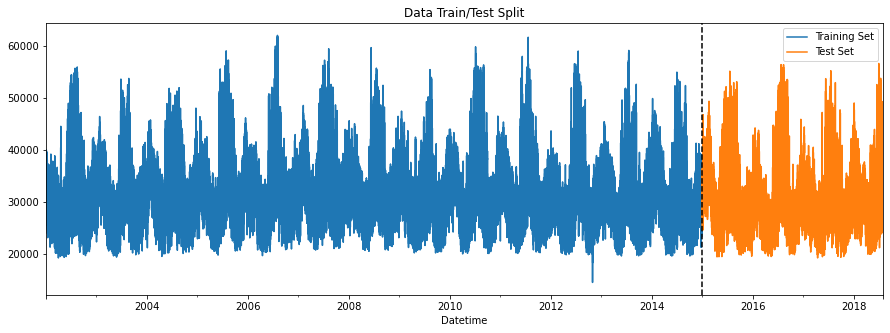

In [42]:
# Train / Test Split
train = df_orig.loc[df_orig.index < '01-01-2015']
test = df_orig.loc[df_orig.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [170]:
# Create features for training and test data
train = create_features(train)
test = create_features(test)

In [171]:
train

,Energy Consumption,Hour,DayofWeek,Quarter,Month,Year,DayOfYear,DayOfMonth,WeekOfYear,DayOfYearFloat
Datetime,,,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,1,1,1.041667
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,1,1,1.083333
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,1,1,1.125000
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,1,1,1.166667
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,1,1,1.208333
...,...,...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,38906.0,19,2,4,12,2014,365,31,1,365.791667
2014-12-31 20:00:00,37772.0,20,2,4,12,2014,365,31,1,365.833333
2014-12-31 21:00:00,36602.0,21,2,4,12,2014,365,31,1,365.875000


In [172]:
test

,Energy Consumption,Hour,DayofWeek,Quarter,Month,Year,DayOfYear,DayOfMonth,WeekOfYear,DayOfYearFloat
Datetime,,,,,,,,,,
2015-01-01 00:00:00,32802.0,0,3,1,1,2015,1,1,1,1.000000
2015-01-01 01:00:00,31647.0,1,3,1,1,2015,1,1,1,1.041667
2015-01-01 02:00:00,30755.0,2,3,1,1,2015,1,1,1,1.083333
2015-01-01 03:00:00,30189.0,3,3,1,1,2015,1,1,1,1.125000
2015-01-01 04:00:00,29890.0,4,3,1,1,2015,1,1,1,1.166667
...,...,...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,2,31,214.833333
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,2,31,214.875000
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,2,31,214.916667


In [173]:
# Define features and target variables

FEATURES = ['DayOfYear', 'Hour', 'DayofWeek', 'Quarter', 'Month', 'Year']
TARGET = 'Energy Consumption'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [174]:
# Create an XGBoost regression model
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
# Fit the model on the training data
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[21:38:48] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32603.50509	validation_1-rmse:31657.42613
[100]	validation_0-rmse:12582.26816	validation_1-rmse:11746.02570
[200]	validation_0-rmse:5836.09015	validation_1-rmse:5366.22689
[300]	validation_0-rmse:3921.26576	validation_1-rmse:4023.63509
[400]	validation_0-rmse:3446.18773	validation_1-rmse:3852.78794
[500]	validation_0-rmse:3286.47496	validation_1-rmse:3808.70584
[600]	validation_0-rmse:3204.88156	validation_1-rmse:3777.27241
[700]	validation_0-rmse:3151.42501	validation_1-rmse:3756.80131
[800]	validation_0-rmse:3111.72340	validation_1-rmse:3738.42921
[900]	validation_0-rmse:3081.06734	validation_1-rmse:3729.20725
[999]	validation_0-rmse:3054.07319	validation_1-rmse:3726.78424


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

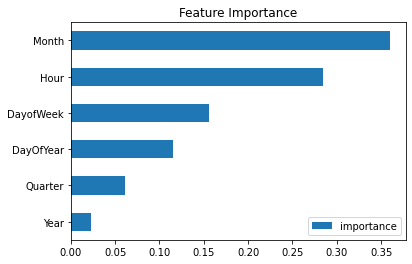

In [175]:
# Plot feature importances
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

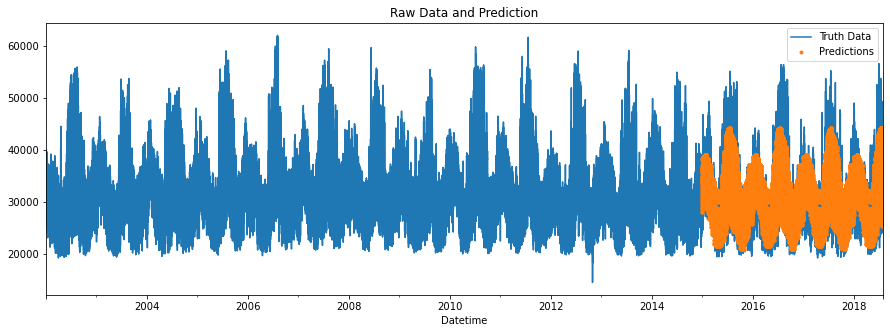

In [187]:
# Make predictions on the test data
test['prediction'] = reg.predict(X_test)
df_orig = df_orig.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df_orig[['Energy Consumption']].plot(figsize=(15, 5))
df_orig['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

In [177]:
test['prediction']

Datetime
2015-01-01 00:00:00    30597.498047
2015-01-01 01:00:00    29506.939453
2015-01-01 02:00:00    28605.074219
2015-01-01 03:00:00    28168.035156
2015-01-01 04:00:00    28087.707031
                           ...     
2018-08-02 20:00:00    42655.664062
2018-08-02 21:00:00    42505.281250
2018-08-02 22:00:00    40780.957031
2018-08-02 23:00:00    37889.957031
2018-08-03 00:00:00    31651.279297
Freq: H, Name: prediction, Length: 31441, dtype: float32

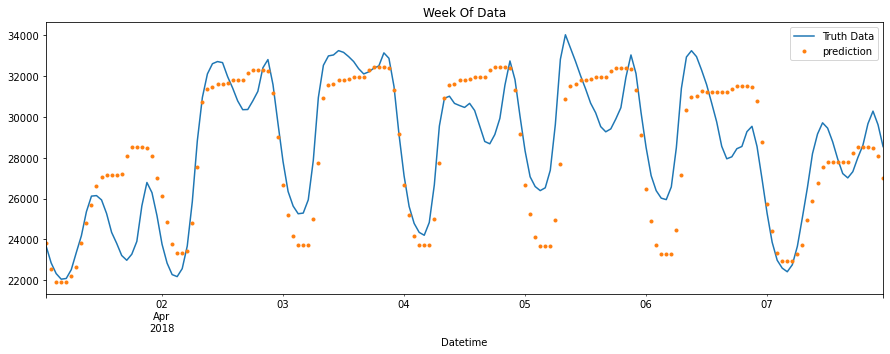

In [189]:
# Plot the raw data and predictions
ax = df_orig.loc[(df_orig.index > '04-01-2018') & (df_orig.index < '04-08-2018')]['Energy Consumption'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df_orig.loc[(df_orig.index > '04-01-2018') & (df_orig.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','prediction'])
plt.show()

In [194]:
# Scoring with Root Mean Squared Error (RMSE)
score = np.sqrt(mean_squared_error(test['Energy Consumption'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 3726.32


In [191]:
# Error Calculation
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2016-08-13    12859.865397
2016-08-14    12793.324544
2016-09-10    11327.278809
2015-02-20    11000.332194
2016-09-09    10842.475260
2018-01-06    10462.798910
2016-08-12    10151.880371
2015-02-21     9897.954427
2015-02-16     9814.756592
2018-01-07     9686.674642
Name: error, dtype: float64

# Prophet Model

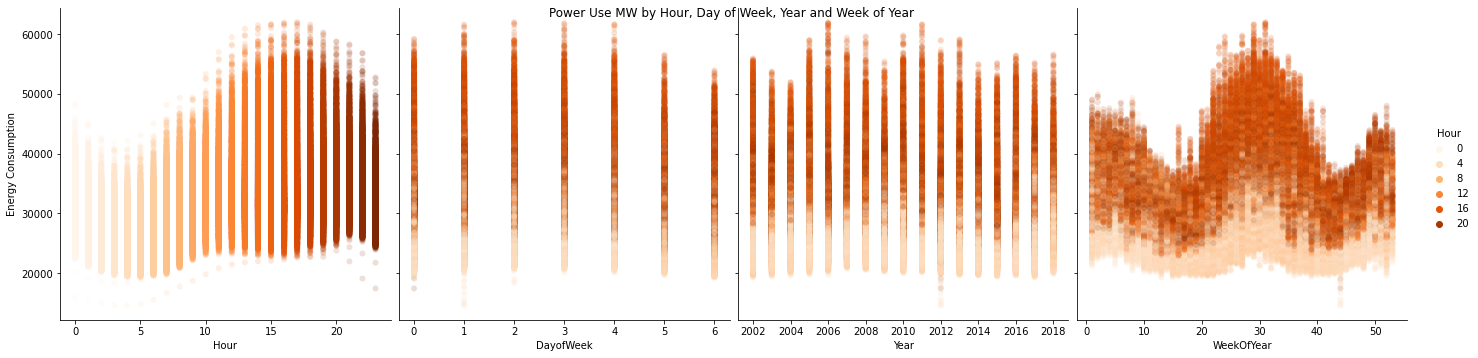

In [69]:
sns.pairplot(df.dropna(),
             hue='Hour',
             x_vars=['Hour','DayofWeek',
                     'Year','WeekOfYear'],
             y_vars='Energy Consumption',
             height=5,
             plot_kws={'alpha':0.15, 'linewidth':0},
             palette='Oranges'
            )
plt.suptitle('Power Use MW by Hour, Day of Week, Year and Week of Year')
plt.show()

In [70]:
# Train/Test Split
# Format data for prophet model using ds and y
train.reset_index() \
    .rename(columns={'Datetime':'ds',
                     'Energy Consumption':'y'}).head()

,ds,y
0,2002-01-01 01:00:00,30393.0
1,2002-01-01 02:00:00,29265.0
2,2002-01-01 03:00:00,28357.0
3,2002-01-01 04:00:00,27899.0
4,2002-01-01 05:00:00,28057.0


In [71]:
# Setup and train the Prophet model and fit
model = Prophet()
model.fit(train.reset_index() \
    .rename(columns={'Datetime':'ds',
                     'Energy Consumption':'y'}))

14:37:15 - cmdstanpy - INFO - Chain [1] start processing
14:38:25 - cmdstanpy - INFO - Chain [1] done processing


In [72]:
# Predict on training set with model
Energy_Consumption_test_fcst = model.predict(test.reset_index() \
    .rename(columns={'Datetime':'ds'}))

In [73]:
Energy_Consumption_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01 00:00:00,31220.350389,26104.921791,34981.366190,31220.350389,31220.350389,-810.965519,-810.965519,-810.965519,-2412.432427,...,1287.725401,1287.725401,1287.725401,313.741507,313.741507,313.741507,0.0,0.0,0.0,30409.384870
1,2015-01-01 01:00:00,31220.314063,24143.840138,32796.961911,31220.314063,31220.314063,-2832.256518,-2832.256518,-2832.256518,-4427.662891,...,1280.378854,1280.378854,1280.378854,315.027518,315.027518,315.027518,0.0,0.0,0.0,28388.057544
2,2015-01-01 02:00:00,31220.277736,22498.556790,31410.346751,31220.277736,31220.277736,-4334.021452,-4334.021452,-4334.021452,-5922.099762,...,1271.723258,1271.723258,1271.723258,316.355052,316.355052,316.355052,0.0,0.0,0.0,26886.256285
3,2015-01-01 03:00:00,31220.241410,21612.090584,30389.855765,31220.241410,31220.241410,-5205.362340,-5205.362340,-5205.362340,-6784.951730,...,1261.865253,1261.865253,1261.865253,317.724136,317.724136,317.724136,0.0,0.0,0.0,26014.879069
4,2015-01-01 04:00:00,31220.205083,21359.966477,30531.334998,31220.205083,31220.205083,-5348.974490,-5348.974490,-5348.974490,-6919.036053,...,1250.926766,1250.926766,1250.926766,319.134798,319.134798,319.134798,0.0,0.0,0.0,25871.230594


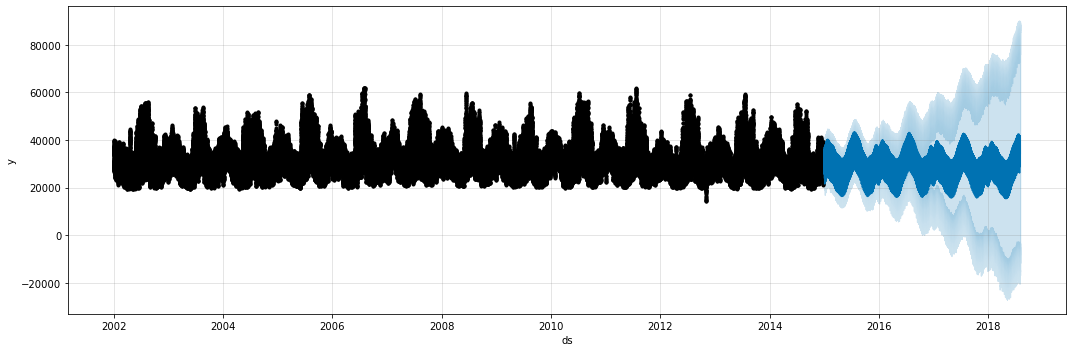

In [74]:
# Plot the forecasted values
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(Energy_Consumption_test_fcst,
                 ax=ax)
plt.show()

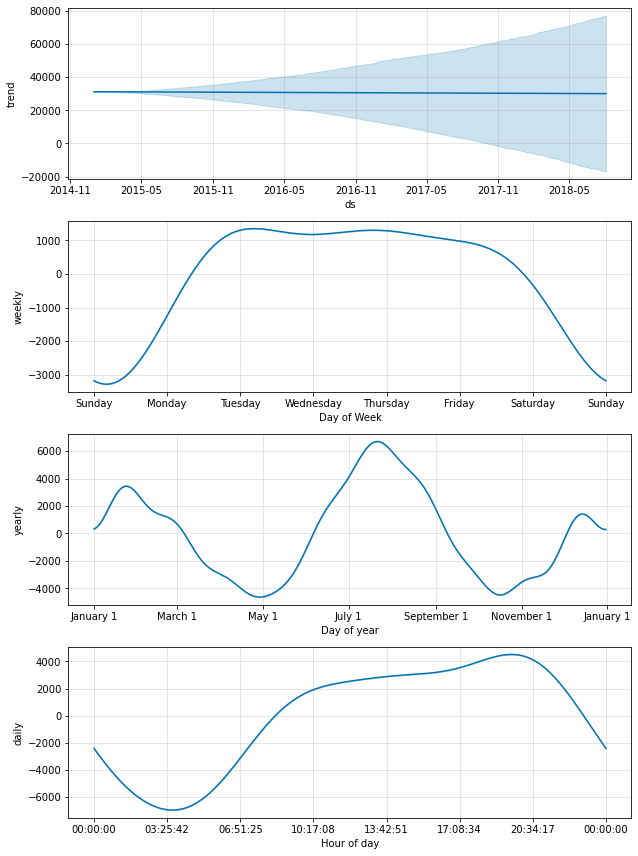

In [75]:
# Plot the components of the model
fig = model.plot_components(Energy_Consumption_test_fcst)

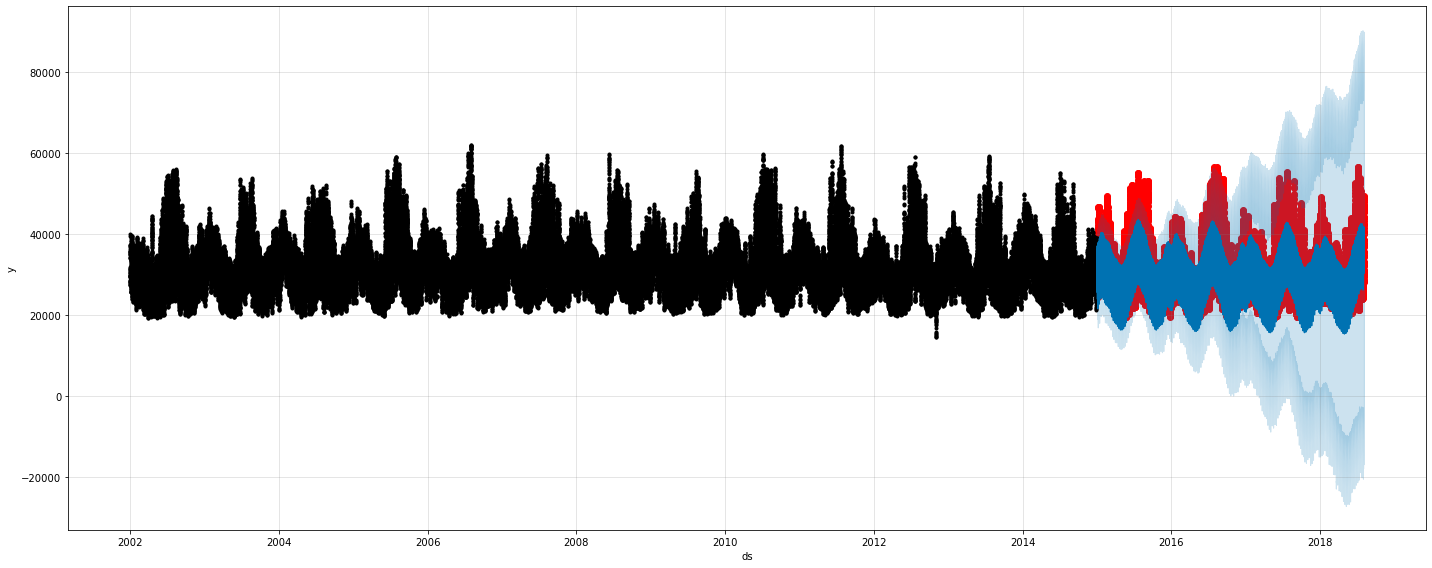

In [93]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(8)
f.set_figwidth(20)
ax.scatter(test.index,  test['Energy Consumption'], color='r')
fig = model.plot(Energy_Consumption_test_fcst, ax=ax)


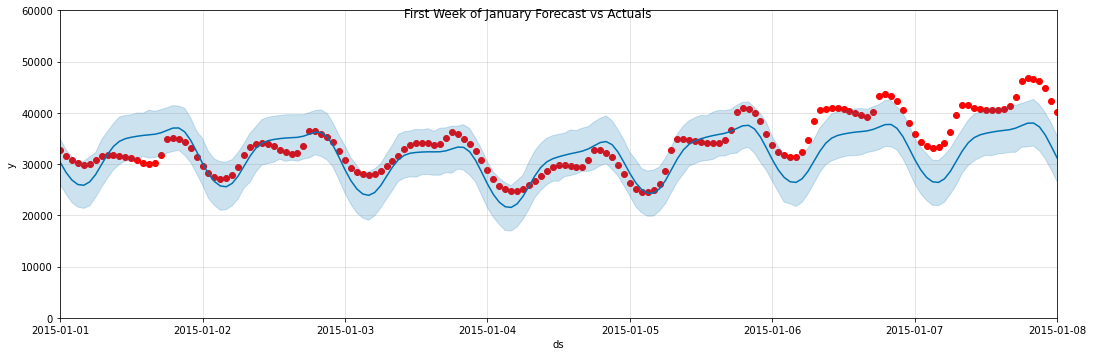

In [98]:
# Plot a single week of predictions
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(test.index, test['Energy Consumption'], color='r')
fig = model.plot(Energy_Consumption_test_fcst, ax=ax)
lower_date = datetime(2015, 1, 1)  # Replace with the desired lower date
upper_date = datetime(2015, 1, 8)  # Replace with the desired upper date
ax.set_xbound(lower=lower_date, upper=upper_date)
ax.set_ylim(0, 60000)
plot = plt.suptitle('First Week of January Forecast vs Actuals')

In [124]:
# Error Metrics
mse = mean_squared_error(y_true=test['Energy Consumption'],
                   y_pred=Energy_Consumption_test_fcst['yhat'])
RMSE = sqrt(mse)
RMSE

4119.085832183718